In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

from umap import UMAP

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

SEED = 42

C:\Users\mexis\anaconda3\envs\main\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\mexis\anaconda3\envs\main\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\mexis\anaconda3\envs\main\Lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

In [2]:
class ClassForAssignment_3:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.data_scaled = None
        self.data_pca = None
        self.data_tsne = None
        self.data_umap = None
        self.n_components_pca = None
        
        self.N_CLUSTERS_RANGE = range(1, 20)
        self.COVARIANCE_TYPE = ['full', 'tied', 'diag', 'spherical']
        
        self.optimal_clusters = None
        self.optimal_covariance = None
        
        self._load_data()
    
    def _load_data(self):
        self.data = pd.read_csv(self.file_path, index_col=0)  # Change this line based on your file format
        
    def normalize_data(self):
        scl = StandardScaler()
        self.data_scaled = scl.fit_transform(self.data)

    def pca_dimensionality_reduction(self):
        print('Selecting optimal number of components for PCA...')
        pca = PCA(random_state=SEED)
        pca.fit(self.data_scaled)
        
        # Calculate explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_
        # Calculate cumulative explained variance
        cum_explained_variance = np.cumsum(explained_variance_ratio)
        
        # Plot cumulative explained variance
        plt.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance, 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance vs. Number of Components')
        plt.show()

        # Find the optimal number of components
        self.n_components_pca = np.argmax(cum_explained_variance >= 0.95) + 1
        print(f"The optimal number of components is {self.n_components_pca}.")
        print('\nPerforming PCA....')
        pca = PCA(n_components=self.n_components_pca, random_state=SEED)
        self.data_pca = pca.fit_transform(self.data_scaled)
        print(' **** Shape of dataset after performing PCA dimensionality reduction:', self.data_pca.shape)
        print()
        
    def tsne_dimensionality_reduction(self):
        print('Performing TSNE for data visualization:')
        tsne = TSNE(n_components=2, random_state=42)
        self.data_tsne = tsne.fit_transform(self.data_scaled)
        print(' **** Shape of dataset after TSNE dimensionality reduction:', self.data_tsne.shape)
        print()
        
    def umap_dimensionality_reduction(self):
        print('Performing UMAP for data visualization:')
        self.data_umap = UMAP(n_components=self.n_components_pca).fit_transform(self.data_scaled)
        print(' **** Shape of dataset after UMAP dimensionality reduction:', self.data_umap.shape)
        print()
    
    # ********* CLUSTERING ****************
    def gaussianmixture(self, method):
        print(f'Selected method: {method}')
        if method=='pca': X = self.data_pca
        elif method=='tsne': X = self.data_tsne
        elif method=='umap': X = self.data_umap
        else:
            return 'Wrong type of method...'
        
        # Initialize variables to store BIC scores, models, and optimal parameters
        bic_scores = []
        models = []
 
        # Fit Gaussian Mixture models with different numbers of components and covariance matrix types
        for n_components in self.N_CLUSTERS_RANGE:
            for covariance_type in self.COVARIANCE_TYPE:
                try:
                    model = GaussianMixture(n_components=n_components,
                                        covariance_type=covariance_type, 
                                        random_state=SEED)
                    model.fit(X)

                except ValueError:
                    model = GaussianMixture(n_components=n_components,
                                        covariance_type=covariance_type, 
                                        reg_covar=0.01,
                                        random_state=SEED)
                    model.fit(X)
    
                bic_scores.append(model.bic(X))
                models.append(model)

                # Update optimal parameters if BIC score is minimum
                if bic_scores[-1] == min(bic_scores):
                    self.optimal_clusters = n_components
                    self.optimal_covariance = covariance_type

        # Get the best model corresponding to the optimal parameters
        best_model_index = bic_scores.index(min(bic_scores))
        best_model = models[best_model_index]

        # Print the optimal number of components and covariance matrix type
        print("Optimal number of components:", self.optimal_clusters)
        print("Optimal covariance matrix type:", self.optimal_covariance)
        print()
        
        # Fit Gaussian Mixture model with the optimal number of components
        model = GaussianMixture(n_components=self.optimal_clusters, 
                                covariance_type=self.optimal_covariance, 
                                random_state=SEED)
        model.fit(X)
        y_pred = model.predict(X)  # Predict the cluster labels
        
#         # Plot the clustering results
#         plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')
#         plt.scatter(model.means_[:, 0], model.means_[:, 1], marker='x', color='red', s=100, label='Cluster Centers')
#         plt.xlabel(' 1')
#         plt.ylabel('Feature 2')
#         plt.title('Clustering Results')
#         plt.legend()
#         plt.show()

In [3]:
dataset = ClassForAssignment_3("Assignment_3_2023_datasets/dataset5.csv")  # Provide the path to your file here

# 1. Dimensionality Reduction

Selecting optimal number of components for PCA...


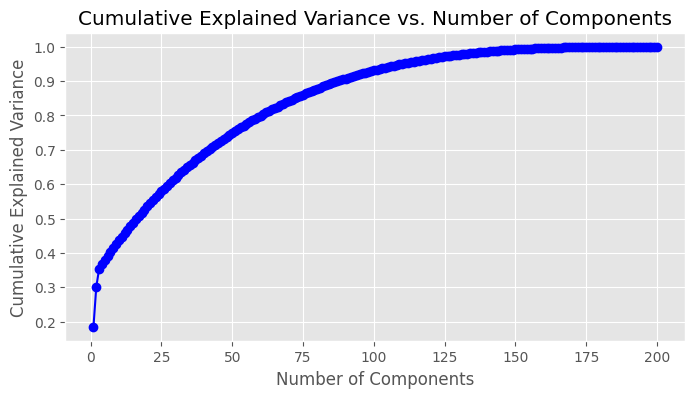

The optimal number of components is 110.

Performing PCA....
 **** Shape of dataset after performing PCA dimensionality reduction: (200, 110)

Performing TSNE for data visualization:
 **** Shape of dataset after TSNE dimensionality reduction: (200, 2)

Performing UMAP for data visualization:
 **** Shape of dataset after UMAP dimensionality reduction: (200, 110)



In [4]:
dataset.normalize_data()

dataset.pca_dimensionality_reduction()

dataset.tsne_dimensionality_reduction()

dataset.umap_dimensionality_reduction()

# Clustering

In [5]:
for method in ['pca','tsne','umap']:
    dataset.gaussianmixture(method=method)

Selected method: pca
Optimal number of components: 4
Optimal covariance matrix type: full
Selected method: tsne
Optimal number of components: 5
Optimal covariance matrix type: spherical
Selected method: umap
Optimal number of components: 1
Optimal covariance matrix type: full
